# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv ("CowboyCigsData.csv")

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


In [4]:
cigData.describe(include = 'all')

,Unnamed: 0,Time,#CigSales
count,144.000000,144,1.440000e+02
unique,NaN,144,NaN
top,NaN,1949-01,NaN
freq,NaN,1,NaN
mean,71.500000,NaN,1.000280e+06
std,41.713307,NaN,1.199663e+02
min,0.000000,NaN,1.000104e+06
25%,35.750000,NaN,1.000180e+06
50%,71.500000,NaN,1.000266e+06
75%,107.250000,NaN,1.000360e+06


In [5]:
cigData.info

<bound method DataFrame.info of      Unnamed: 0     Time  #CigSales
0             0  1949-01    1000112
1             1  1949-02    1000118
2             2  1949-03    1000132
3             3  1949-04    1000129
4             4  1949-05    1000121
..          ...      ...        ...
139         139  1960-08    1000606
140         140  1960-09    1000508
141         141  1960-10    1000461
142         142  1960-11    1000390
143         143  1960-12    1000432

[144 rows x 3 columns]>

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [6]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

There are three columns.   

\* Previous answer.  See note with 2a. below.  "There are two columns in the data, time and number of cigarette sales.  (Without including "index_col=0" when reading in the data, there would be three columns.  However, the first of these is simply repeated index numbers.)"

Let's check out the data types of our columns.

In [7]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


Check whether there are any null values. 

In [8]:
cigData.isnull().any()

Unnamed: 0    False
Time          False
#CigSales     False
dtype: bool

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [9]:
cigData.drop('Unnamed: 0', axis=1, inplace = True)

\*Note:  I had included "index_col=0" when reading in the data to eliminate the additional column upon loading the data, which avoided the need for this step.  But following this instruction, I edited to keep that column until deleting it now.  (This also affected the answer in part 1c. asking how many columns there are.)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [10]:
cigData.rename(columns = {'Time':'Month'}, inplace = True)

Call a head() to check this has worked. 

In [11]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [12]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.set_index('Month', inplace = True)

In [13]:
cigData.tail()

,#CigSales
Month,
1960-08-01,1000606
1960-09-01,1000508
1960-10-01,1000461
1960-11-01,1000390
1960-12-01,1000432


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [14]:
y = cigData['#CigSales']

\* I believe that "#Passenger column" is a typo in the question and that it is intending to ask for #CigSales instead.  However, if this is not the case, the following responses will be inaccurate, and I will correct them.

Check the type of our new variable. 

In [15]:
type(y)

pandas.core.series.Series

In [16]:
y

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
               ...   
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432
Name: #CigSales, Length: 144, dtype: int64

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [17]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

Text(0.5, 1.0, 'Cigarette sales by year')

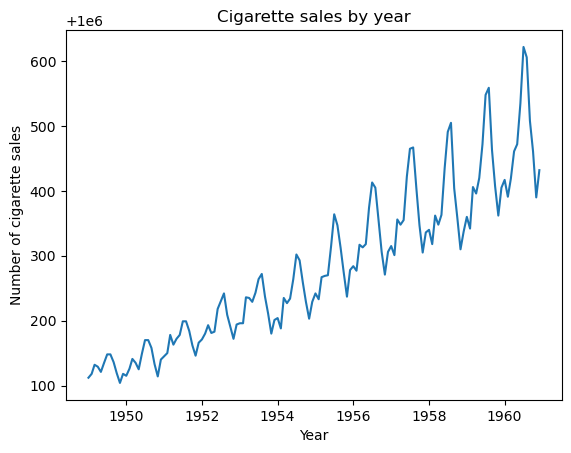

In [18]:
plt.plot(y)

plt.xlabel('Year')
plt.ylabel('Number of cigarette sales')
plt.title('Cigarette sales by year')

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-----It seems to me that the data would work best with a multiplicative model.--------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the original data, the trend, the seasonality, and the residuals 

decomp = seasonal_decompose(y)

trend = decomp.trend
seasonal = decomp.seasonal
noise = decomp.resid

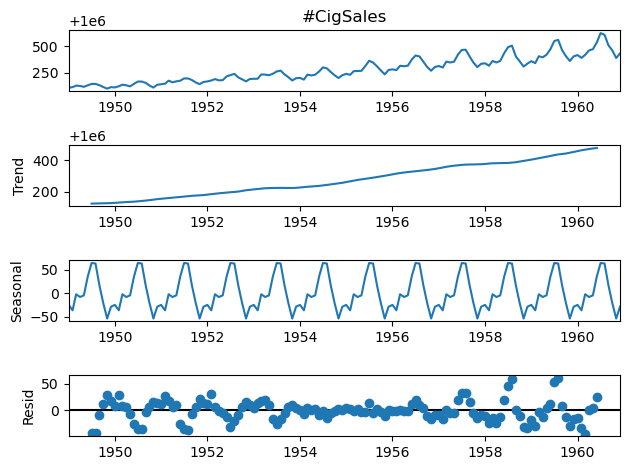

In [20]:
decomp.plot()
plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [21]:
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\Users\crathgeb-pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

<AxesSubplot: xlabel='Month'>

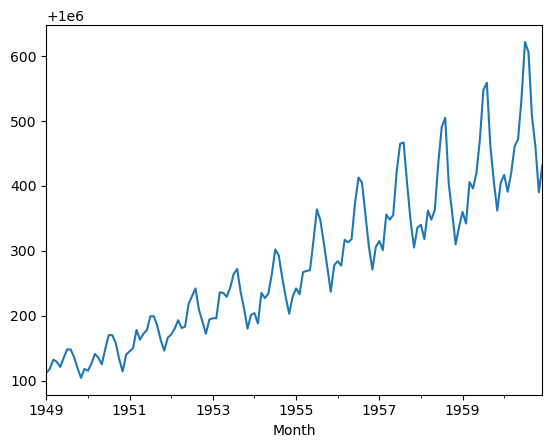

In [22]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [23]:
y2 = np.log(y)

In [24]:
y2

Month
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
                ...    
1960-08-01    13.816116
1960-09-01    13.816018
1960-10-01    13.815971
1960-11-01    13.815900
1960-12-01    13.815942
Name: #CigSales, Length: 144, dtype: float64


When you plot this, you can see how the variance in our data now remains contant over time.

<AxesSubplot: xlabel='Month'>

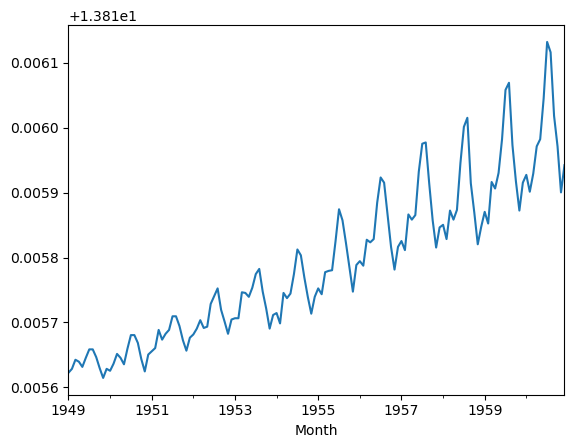

In [25]:
y2.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [26]:
diff = y2.diff().dropna()

In [27]:
diff

Month
1949-02-01    0.000006
1949-03-01    0.000014
1949-04-01   -0.000003
1949-05-01   -0.000008
1949-06-01    0.000014
                ...   
1960-08-01   -0.000016
1960-09-01   -0.000098
1960-10-01   -0.000047
1960-11-01   -0.000071
1960-12-01    0.000042
Name: #CigSales, Length: 143, dtype: float64

In [28]:
kpss(diff)

C:\Users\crathgeb-pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.02389767420757057,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [29]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

\* Attempting it on my own, I first developed a function for mse in general, but I couldn't quite step from there to adding the pieces for the arima model.  So I did use hints from tier 2 to develop the working function.

In [30]:
def my_mse(y, y_bar):
    summation = 0
    n = len(y)
    for i in range (0, n):
        difference = y[i] - y_bar[i]
        squared_difference = difference**2
        summation = summation + squared_difference
    MSE = summation/n
    print("MSE = ", MSE)

In [31]:
def evaluate_arima_model(data, arima_order):
    split = int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    predictions = list()
 
    for i in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    error = mean_squared_error(test, predictions)
    
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [32]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, ps, ds, qs):
    best_score, best_cfg = float("inf"), None
    for p in ps:
        for d in ds:
            for q in qs:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [33]:
# Now, we choose a couple of values to try for each parameter.
ps = [0, 1, 2]
ds = [0, 1, 2]
qs = [0, 1, 2]

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
evaluate_models(diff, ps, ds, qs)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 0, 2) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 1, 2) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(1, 2, 1) MSE=0.000
ARIMA(1, 2, 2) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 0, 2) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
Best ARIMA(2, 0, 1) MSE=0.000


\*Well.  The first result I got was that the best mse was infinity, which did not seem accurate or useful.  After many more attempts and debugging throughout the case study as well as this section, I finally found a solution that appears to provide useful analysis.

So the best p, d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [51]:
p = 2
d = 1
q = 1
model = ARIMA(diff, order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [52]:
y2.describe()

count    144.000000
mean      13.815791
std        0.000120
min       13.815615
25%       13.815691
50%       13.815776
75%       13.815871
max       13.816132
Name: #CigSales, dtype: float64

We can take a look at a summary of the model this library has built around our data.

In [53]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1248.558
Date:                Fri, 02 Jun 2023   AIC                          -2489.116
Time:                        10:54:48   BIC                          -2477.292
Sample:                    02-01-1949   HQIC                         -2484.311
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4017   2.38e-19   1.69e+18      0.000       0.402       0.402
ar.L2         -0.1224   6.09e-19  -2.01e+17      0.000      -0.122      -0.122
ma.L1         -0.7036   5.89e-19   -1.2e+18      0.000      -0.704      -0.704
sigma2      1.414e-09   2.97e-10      4.757      0.000    8.32e-10       2e-09
===================================================================================
Ljung-Box (L1) (Q):                   3.52   Jarque-Bera (JB):                 4.10
Prob(Q):                              0.06   Prob(JB):                         0.13
Heteroskedasticity (H):               7.69   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.36e+33. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

Text(0.5, 1.0, 'Modeled changes in cigarette sales over time')

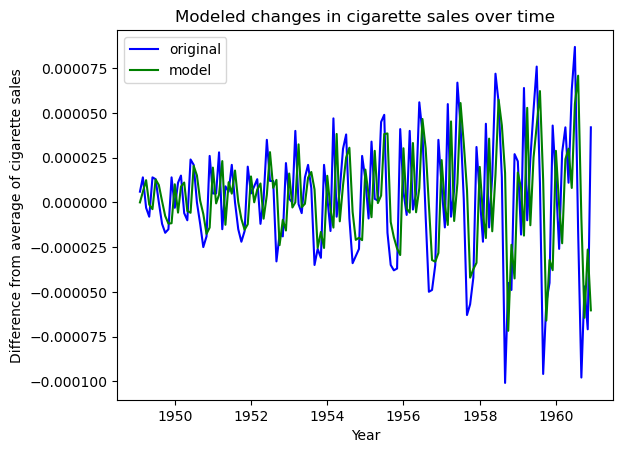

In [54]:
plt.plot(diff, color = 'blue')
plt.plot(model_fit.predict(), color = 'green')
plt.legend(['original', 'model'])

plt.xlabel('Year')
plt.ylabel('Difference from average of cigarette sales')
plt.title('Modeled changes in cigarette sales over time')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [55]:
y2

Month
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
                ...    
1960-08-01    13.816116
1960-09-01    13.816018
1960-10-01    13.815971
1960-11-01    13.815900
1960-12-01    13.815942
Name: #CigSales, Length: 144, dtype: float64

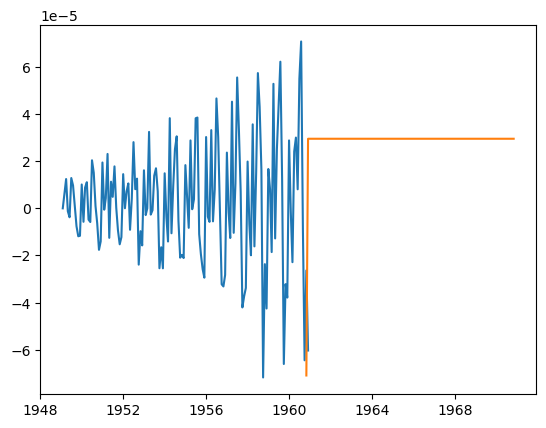

In [74]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

forecast_period = 120
date_range = pd.date_range(y2.index[-1], freq = 'MS', periods = forecast_period).strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your prediction

future_months = pd.DataFrame(date_range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]
                         
# Plot your future predictions

plt.plot(model_fit.predict())
plt.plot(diff['Nov 1960'].append(future_months['Prediction']))
plt.show()

\*Notes:  I am not particularly happy with these results.  From further reading, it appears as though some of my hesitation is a common or perhaps unavoidable issue with ARIMA models.  According to one coder on stack overflow, discussing a model with one autoregressive period (the one from this case study has 2, however, this seems applicable): "Your model only has a memory of 1 period, so the current prediction is entirely determined by the 1 value of the prior period. It's not a very complex model; it's not doing anything fancy with all the prior values. It's just taking yesterday's price, multiplying it by some value and adding a constant. You should expect it to quickly go to equilibrium and then stay there forever."  [Stack overflow post](https://stackoverflow.com/questions/38723825/forecasting-with-statsmodels/  'Reference to the quote and its context on stack overflow')

This appears to be what the final model forecast shows.  While this could be useful looking at only the future couple of periods, or maybe a few longer, using it to forecast years into the future will not provide useful information.  I will quickly edit this to see if a shorter period offers more information, but I think that I need to learn more about this type of modeling.  I am also still uncertain whether the logged y or difference in y was the intended target variable.  I believe that using either can provide information about the trends, but I would like to learn and practice more with these kinds of smoothing, normalizing, etc in models to ensure that I fully understand and am using them correctly.  This is an article I'd like to come back to as I look into the topic more:  [AMIRA modeling](https://www.johnwittenauer.net/a-simple-time-series-analysis-of-the-sp-500-index/  'Simple time series analysis example using ARIMA model')

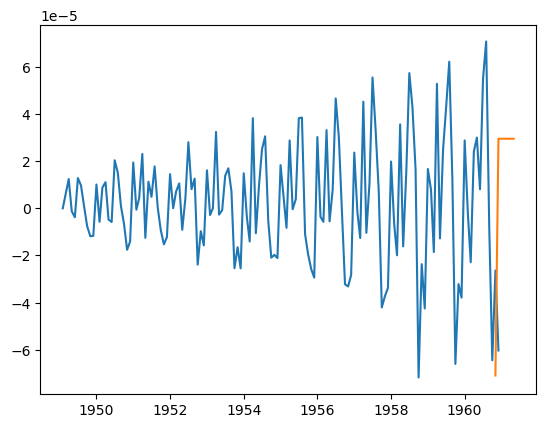

In [86]:
forecast_period = 6
date_range = pd.date_range(y2.index[-1], freq = 'MS', periods = forecast_period).strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your prediction

future_months = pd.DataFrame(date_range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]
                         
# Plot your future predictions

plt.plot(model_fit.predict())
plt.plot(diff['Nov 1960'].append(future_months['Prediction']))
plt.show()

\* As I suspected, the shorter period does stick more closely to the model's history compared to examining up to 10 years into the future.  After the first month or two, the forecast appears to fully level out at the same level regardless of date range.

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 